# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [111]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

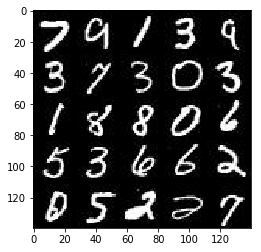

In [112]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

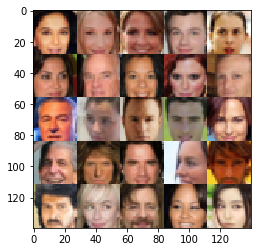

In [113]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [114]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [115]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name='inputs_real')
    
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim),name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_images, z_input, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [116]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x16
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # Leaky ReLU
        relu1 = tf.maximum(alpha * x1, x1)
       
        # 16x16x32
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # Leaky ReLU
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 8x8x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        # Leaky ReLU
        relu3 = tf.maximum(alpha * bn3, bn3)
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [117]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # Leaky ReLU
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # Leaky ReLU
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [118]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Build the model
    g_model = generator(input_z, out_channel_dim,alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real,alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True,alpha=alpha)

    # Calculate the loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [119]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
   # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [120]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [121]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Multiply batch_images by 2.0 
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1748... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.1757... Generator Loss: 11.6769
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.9523
Epoch 1/2... Discriminator Loss: 2.0025... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 2.1615... Generator Loss: 0.3508
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.3915
Epoch 1/2... Discriminator Loss: 3.1931... Generator Loss: 0.1473
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 3.3562
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.6468


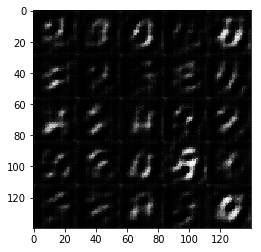

Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 1.8122
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 2.8377
Epoch 1/2... Discriminator Loss: 1.9919... Generator Loss: 2.1014
Epoch 1/2... Discriminator Loss: 2.7297... Generator Loss: 3.5732
Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 2.4879
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.5431
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 3.5101
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 2.9744
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.7440


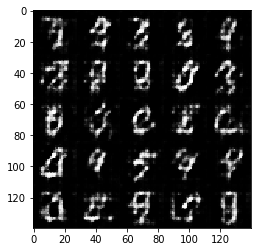

Epoch 1/2... Discriminator Loss: 2.1638... Generator Loss: 2.6854
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 2.2082... Generator Loss: 2.8821
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 2.6163
Epoch 1/2... Discriminator Loss: 2.0203... Generator Loss: 0.3280
Epoch 1/2... Discriminator Loss: 2.6639... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.4402


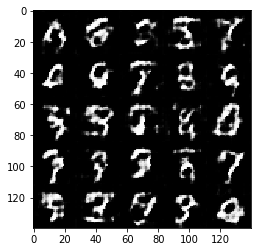

Epoch 1/2... Discriminator Loss: 2.2841... Generator Loss: 3.6685
Epoch 1/2... Discriminator Loss: 0.7033... Generator Loss: 1.9604
Epoch 1/2... Discriminator Loss: 1.8045... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 3.4446... Generator Loss: 0.0611
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 2.4202
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 4.0008... Generator Loss: 0.0363
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.3855


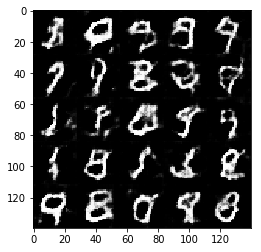

Epoch 1/2... Discriminator Loss: 1.6025... Generator Loss: 2.0780
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 2.1415... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4622
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 1.0074
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.8333


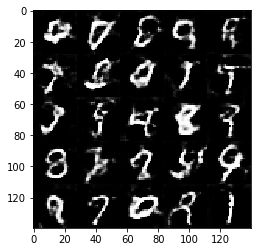

Epoch 1/2... Discriminator Loss: 2.0624... Generator Loss: 2.3199
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 0.4278
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 1.7371
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.8108... Generator Loss: 0.2973
Epoch 1/2... Discriminator Loss: 3.4731... Generator Loss: 0.0686
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.4785


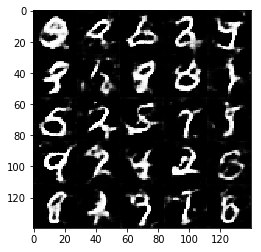

Epoch 1/2... Discriminator Loss: 2.1095... Generator Loss: 3.1046
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 2.5533
Epoch 1/2... Discriminator Loss: 1.6940... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.5703
Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 1.8441
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 1.2429


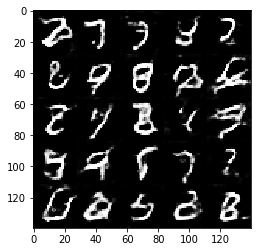

Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.4613
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.1578
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 1.8249
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 1.0294
Epoch 1/2... Discriminator Loss: 1.8591... Generator Loss: 3.2027
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.4168


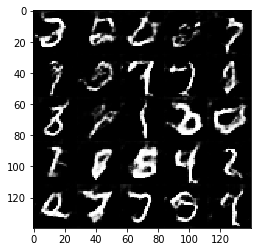

Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.9989
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 1.2018
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 1.8886
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.8653


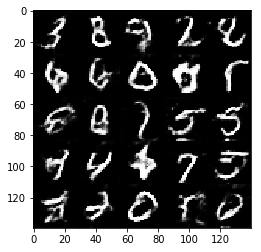

Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.6084
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 2.4105
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.2487
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.9406


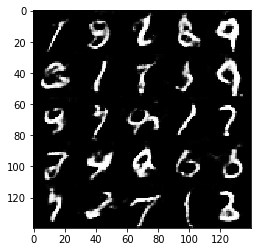

Epoch 2/2... Discriminator Loss: 1.0981... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.9628
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 2.3400
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 1.0258
Epoch 2/2... Discriminator Loss: 1.7018... Generator Loss: 0.3205
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 2.2264
Epoch 2/2... Discriminator Loss: 1.8990... Generator Loss: 0.2835
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.5685


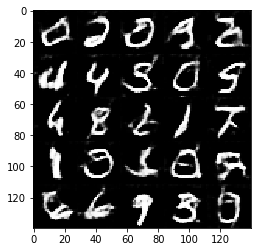

Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 0.8993
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 0.9589
Epoch 2/2... Discriminator Loss: 1.9725... Generator Loss: 0.2287
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.2924
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 1.3792
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.6886... Generator Loss: 3.0629
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.4228
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.1708


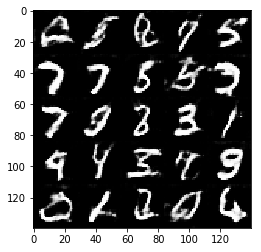

Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 1.2595
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 1.2924
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.8571
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.6169
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 1.0745
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 1.9224... Generator Loss: 0.2731
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.4477


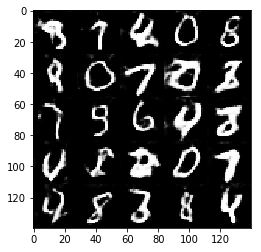

Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 1.5842
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.5295
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 1.8057
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.7441... Generator Loss: 0.3874


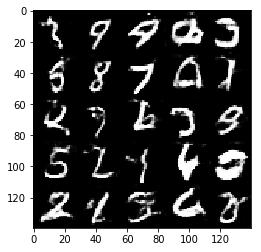

Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.7154... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.5695
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 2.8399... Generator Loss: 4.8489
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 0.8182


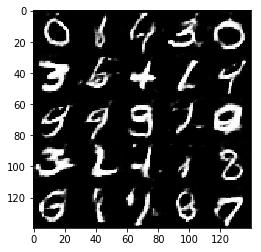

Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 2.3310... Generator Loss: 0.1682
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 1.7244... Generator Loss: 0.2719
Epoch 2/2... Discriminator Loss: 2.9009... Generator Loss: 5.0360
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 0.7187


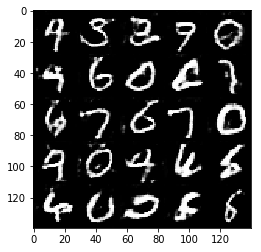

Epoch 2/2... Discriminator Loss: 2.3506... Generator Loss: 4.2357
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 2.1811
Epoch 2/2... Discriminator Loss: 0.7202... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.6767... Generator Loss: 0.3441
Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.7757... Generator Loss: 0.3284


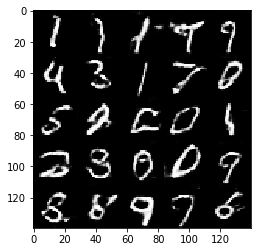

Epoch 2/2... Discriminator Loss: 0.9157... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.9275
Epoch 2/2... Discriminator Loss: 1.5816... Generator Loss: 3.6552
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 0.9915
Epoch 2/2... Discriminator Loss: 1.6206... Generator Loss: 0.3493
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.5735


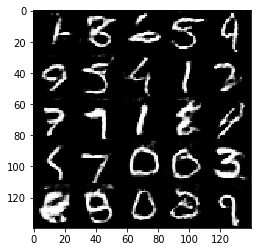

Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 2.3364
Epoch 2/2... Discriminator Loss: 1.9464... Generator Loss: 0.2401
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 1.0533
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.9795... Generator Loss: 0.2686
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 0.9408


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9957... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 1.7094... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 2.5651
Epoch 1/1... Discriminator Loss: 5.2845... Generator Loss: 7.7044
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 3.8168... Generator Loss: 0.1262
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 4.7486
Epoch 1/1... Discriminator Loss: 2.4114... Generator Loss: 4.2406


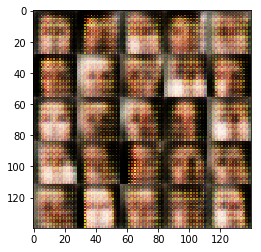

Epoch 1/1... Discriminator Loss: 2.2179... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 3.2680... Generator Loss: 0.2128
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 1.6390
Epoch 1/1... Discriminator Loss: 2.1390... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 2.3154... Generator Loss: 2.3271
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.0871


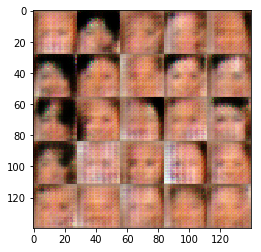

Epoch 1/1... Discriminator Loss: 2.8504... Generator Loss: 0.1614
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 2.1178... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7628


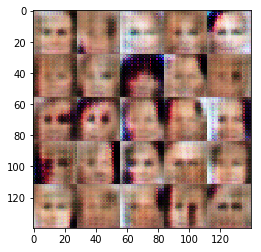

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 2.4646
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 2.1488... Generator Loss: 0.1532
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 1.2715


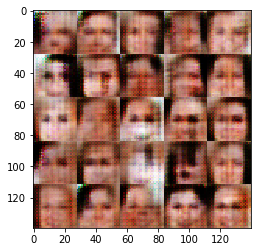

Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.8182... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.9014


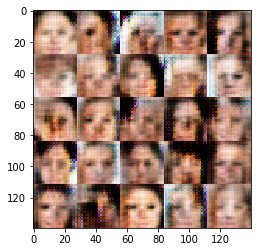

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 2.5377
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 2.3471
Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8794


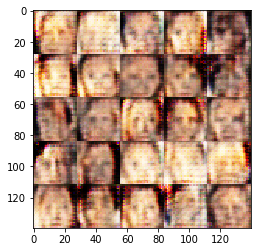

Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.5253
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.1579


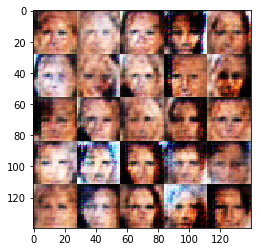

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.9060... Generator Loss: 0.4192


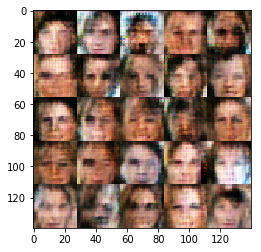

Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 2.2229... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 1.5932


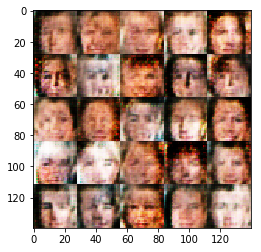

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.4773


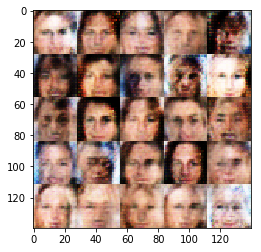

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7778


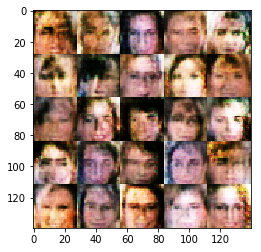

Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.9602... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.9275


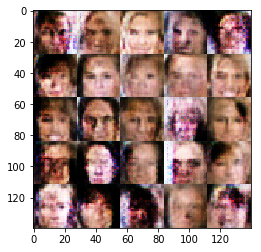

Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.1258


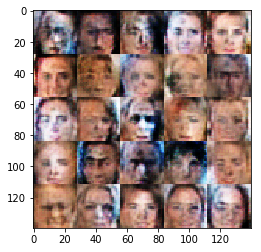

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7446


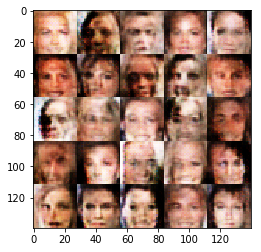

Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5572


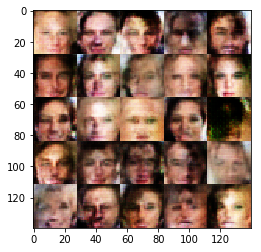

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 1.7191
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.0322


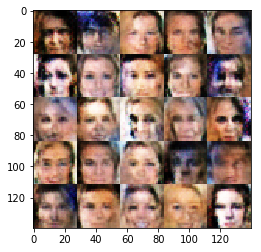

Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.9503


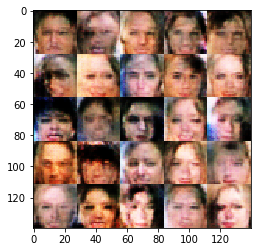

Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8132


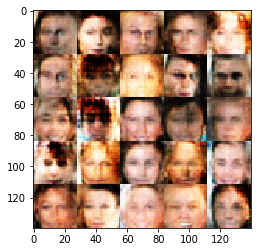

Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.5869
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8534


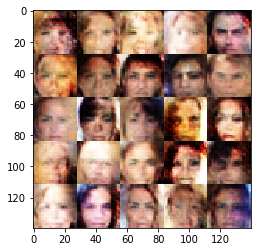

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 1.9378
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6828


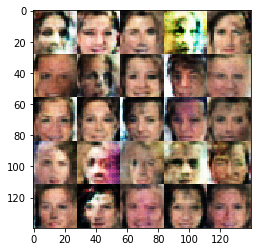

Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.3969


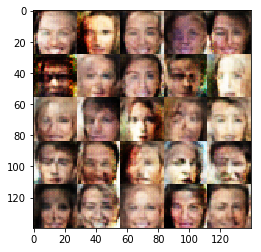

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.3952
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.1148


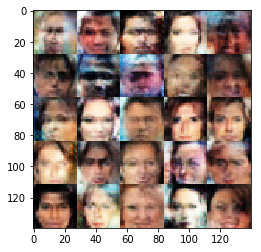

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7099


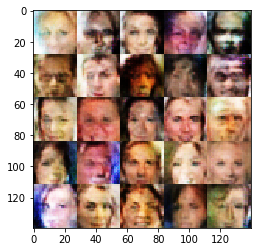

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7752


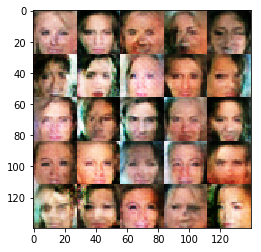

Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9610


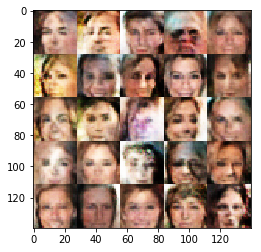

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.8243


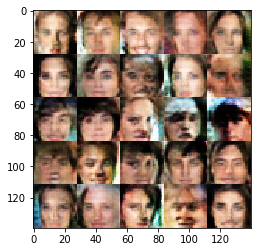

Epoch 1/1... Discriminator Loss: 1.6780... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 2.1006... Generator Loss: 0.2023
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 1.5750


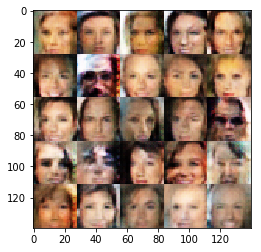

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7811


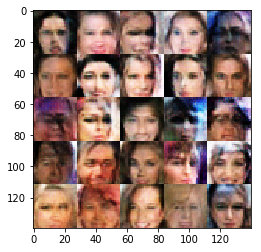

Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 1.0002


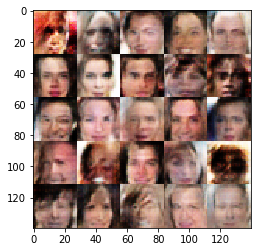

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6322


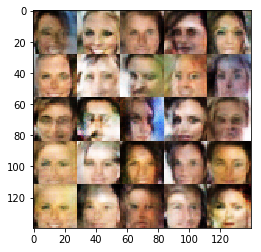

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 1.7910
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6887


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.